In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else "cpu"

In [2]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transfrom = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase):
        return self.data_transfrom[phase](img)

In [3]:
cat_dir = r'./data/dogs-vs-cats/Cat/'
dog_dir = r'./data/dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_dir, f) for f in os.listdir(cat_dir)])
dog_images_filepaths = sorted([os.path.join(dog_dir, f) for f in os.listdir(dog_dir)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [4]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12,6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = 'green' if true_label == predicted_label else 'red'
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color= color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

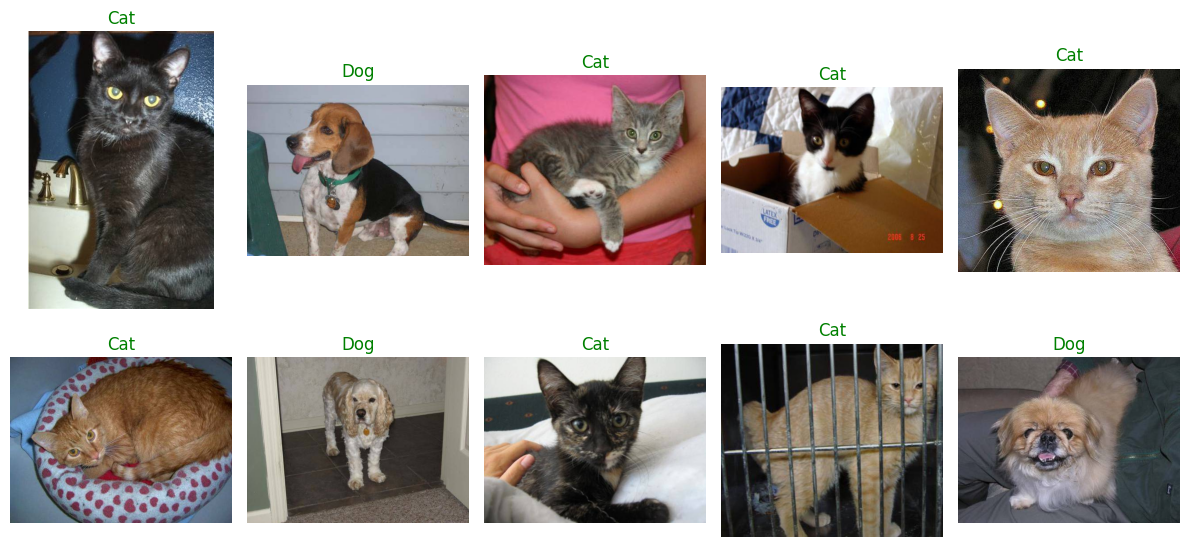

In [5]:
display_image_grid(test_images_filepaths)

In [6]:
class DogCatDataset(Dataset):
    def __init__(self, file_list, transform, phase):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, i):
        img_path = self.file_list[i]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        else:
            label = 0
        return img_transformed, label

In [7]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [8]:
train_dataset= DogCatDataset(
    train_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'train')
val_dataset = DogCatDataset(
    val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 1])


In [10]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, 5, 1, 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(32*53*53, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [11]:
model = LeNet()
print(model)

LeNet(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=89888, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
    (3): Softmax(dim=1)
  )
)


In [12]:
from torchsummary import summary
model.to(device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
              ReLU-8                  [-1, 512]               0
            Linear-9                    [-1, 2]           1,026
          Softmax-10                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Es

In [13]:
def count_parameter(mode):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameter(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [14]:
optim = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [15]:
import time

def train_model(model, dataloader_dict, criterion, optim, num_epoch):
    start = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print(f'Epoch {epoch+1}/{num_epoch}')
        print('-' * 20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corr = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs.to(device))
                    loss = criterion(preds, labels.to(device))
                    
                    if phase == 'train':
                        optim.zero_grad()
                        loss.backward()
                        optim.step()
                    
                    preds = torch.max(preds, dim=1)[1]
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corr += preds.eq(labels.to(device)).sum().item()
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corr / len(dataloader_dict[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = model
                
    end = time.time() - start
    
    print(f'Training complete in {end // 60:.0f}m {end % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    return best_model

In [16]:
num_epoch = 10
best_model = train_model(model, dataloader_dict, criterion, optim, num_epoch)

Epoch 1/10
--------------------


/tmp/ipykernel_357632/3380989606.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5075


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6940 Acc: 0.5326
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6883 Acc: 0.5550


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6942 Acc: 0.5435
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6844 Acc: 0.6000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6959 Acc: 0.4783
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6806 Acc: 0.5900


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6962 Acc: 0.5217
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6807 Acc: 0.6025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6957 Acc: 0.5109
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6744 Acc: 0.6050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6938 Acc: 0.5109
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6739 Acc: 0.6025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6939 Acc: 0.5326
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6699 Acc: 0.6100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6888 Acc: 0.5435
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6647 Acc: 0.6200


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6897 Acc: 0.5435
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6527 Acc: 0.6675


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6839 Acc: 0.5870
Training complete in 0m 7s
Best val Acc: 0.5870


In [17]:
import pandas as pd

id_list = []
pred_list = []
_id = 0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)
        
        best_model.eval()
        outputs = best_model(img)
        preds = torch.max(outputs, 1)[0].item()
        id_list.append(_id)
        pred_list.append(preds)
        
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('./data/LesNet.csv', index=False)

/tmp/ipykernel_357632/2953272744.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
res.head(10)

,id,label
0,109,0.527410
1,145,0.702782
2,15,0.583933
3,162,0.555466
4,167,0.536476
5,200,0.508329
6,210,0.602237
7,211,0.641087
8,213,0.624084
9,224,0.659847


In [19]:
class_ = classes = {0: 'cat', 1: 'dog'}

def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

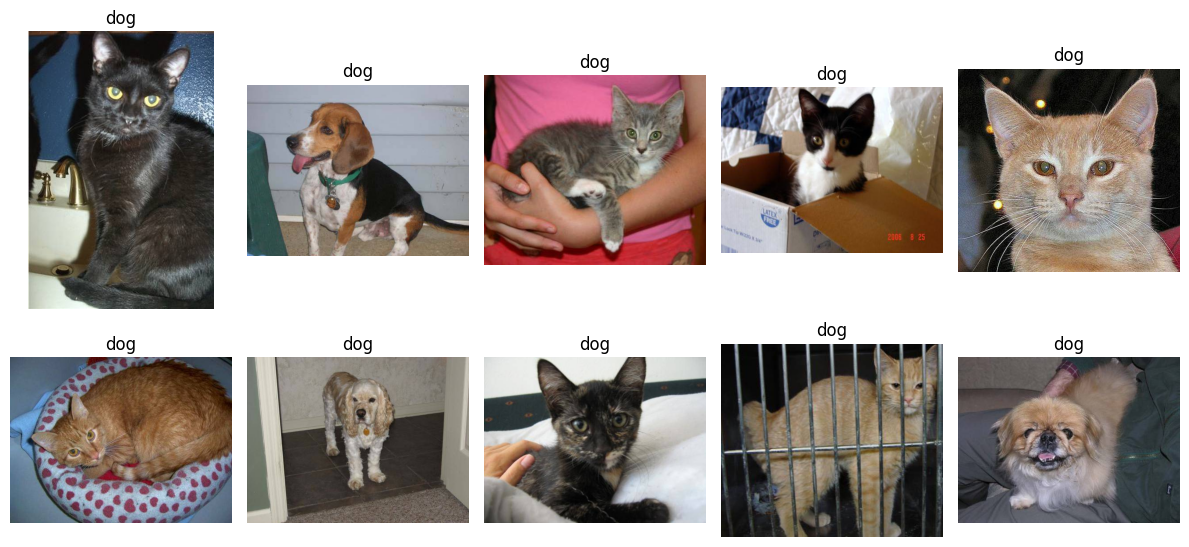

In [20]:
display_image_grid(test_images_filepaths)